# Using a Multiple Linear Regression Model on the Boston Housing Dataset to Predict House Price

The objective of this program is to utilise a multiple linear regression model with the Boston Housing dataset (available from sklearn) to predict house prices from variables such as local crime rate, pupil-student ratio of town, rooms per home, and local population social class. We will proceed with some simple data exploration before scaling the features, tuning the hyperparameters, and looking at ways the model performance can be improved. 

We begin by loading the dataset, creating a dataframe and shuffling the data to ensure there are no patterns or biases.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import seaborn as sns
import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

boston = load_boston()
# boston is imported as a bunch, a subclass of dictionary type
# load as a DataFrame
df = pd.DataFrame(boston['data'], columns = boston['feature_names'])
# add the target data to df
df['MEDV'] = boston.target
# shuffle data frame before use with sklearn
df = shuffle(df)

The variables in the dataset are as follows:

CRIM: per capital crime rate by town

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.   

INDUS: proportion of non-retail business acres per town

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX: nitric oxides concentration (parts per 10 million)

RM: average number of rooms per dwelling

AGE: proportion of owner-occupied units built prior to 1940

DIS: weighted distances to five Boston employment centres

RAD: index of accessibility to radial highways

TAX: full-value property-tax rate per $10,000

PTRATIO: pupil-teacher ratio by town

B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT: % lower status of the population

MEDV: Median value of owner-occupied homes in $1000's

In [16]:
# view data frame
df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
252,0.08221,22.0,5.86,0.0,0.431,6.957,6.8,8.9067,7.0,330.0,19.1,386.09,3.53,29.6
158,1.34284,0.0,19.58,0.0,0.605,6.066,100.0,1.7573,5.0,403.0,14.7,353.89,6.43,24.3
101,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5
414,45.74610,0.0,18.10,0.0,0.693,4.519,100.0,1.6582,24.0,666.0,20.2,88.27,36.98,7.0
217,0.07013,0.0,13.89,0.0,0.550,6.642,85.1,3.4211,5.0,276.0,16.4,392.78,9.69,28.7
160,1.27346,0.0,19.58,1.0,0.605,6.250,92.6,1.7984,5.0,403.0,14.7,338.92,5.50,27.0
18,0.80271,0.0,8.14,0.0,0.538,5.456,36.6,3.7965,4.0,307.0,21.0,288.99,11.69,20.2
404,41.52920,0.0,18.10,0.0,0.693,5.531,85.4,1.6074,24.0,666.0,20.2,329.46,27.38,8.5
87,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
292,0.03615,80.0,4.95,0.0,0.411,6.630,23.4,5.1167,4.0,245.0,19.2,396.90,4.70,27.9


Before we work with the regression model it is important to check that there are no missing or nan values in the data.

In [17]:
# check for missing values and nan values
print(df.isnull().sum())
print('\n')
print('Nan values present: {}'.format(df.isnull().values.any()))

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


Nan values present: False


We expect the target variable to have an approximately normal distribution. Now we can verify this.

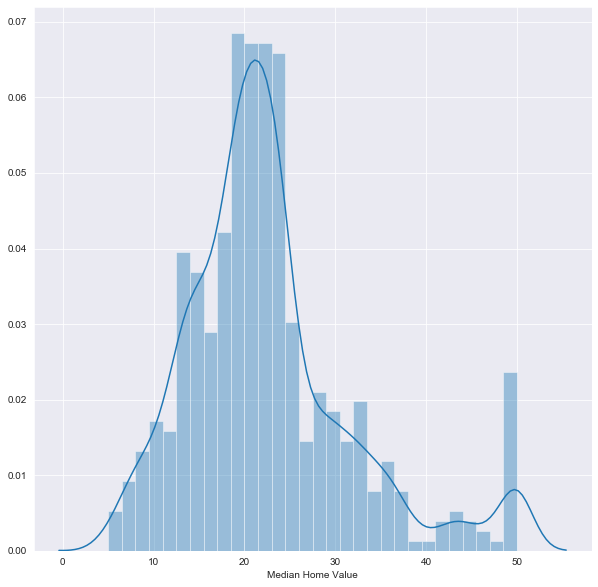

In [18]:
# plot the distribution of the target variable using seaborn
# displot plots the data curve and the corresponding histogram
y = pd.Series(df['MEDV'], name = 'Median Home Value')
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = sns.distplot(y, bins = 30)
plt.show()

The target variable has a right-skewed (roughly) normal distribution, with some outliers at the higher end of the range. These may have to be removed to improve model performance.

We can gain an insight into the relationships between the variables by generating a correlation matrix and pairplot. 

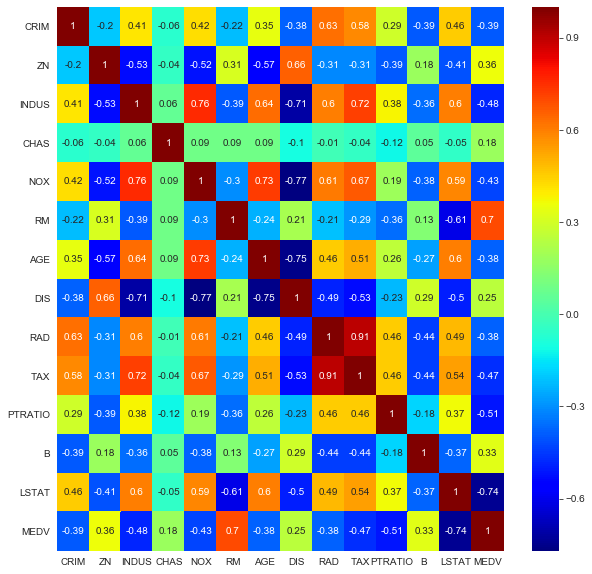

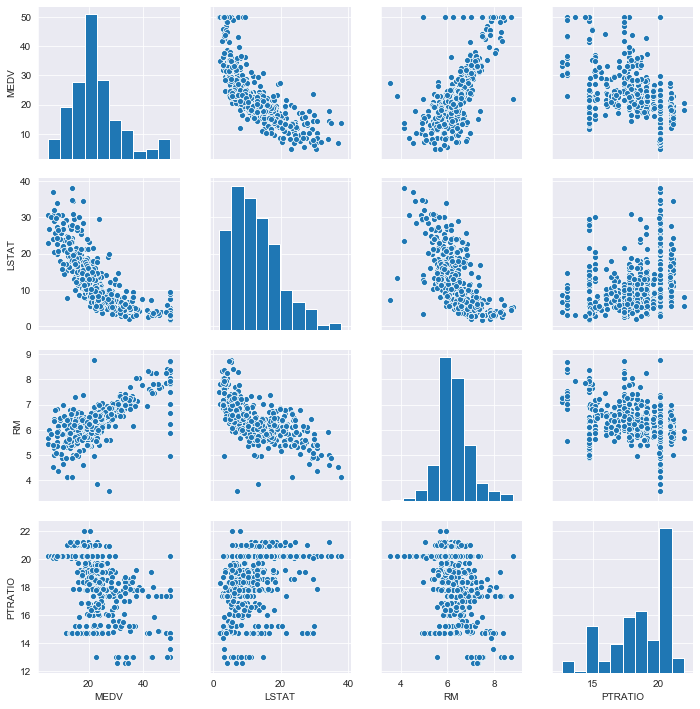

In [19]:
# create a correlation matrix that measures the relationships between the variables
correlation_matrix = df.corr().round(2)
# use the seaborn heatmap function to visualise the matrix
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(correlation_matrix, annot = True, cmap = 'jet')
# plot some of the most important features with the target variable
ax = sns.pairplot(df[['MEDV', 'LSTAT', 'RM', 'PTRATIO']])

The features most strongly correlated with the target (MEDV) are RM and LSTAT. We appear to have some collinearity in the dataset, such as between the features RAD and TAX for example. We may have to address this issue if model performance in not satisfactory. 

Now we assign the features to X.

In [20]:
# assign the features to X
X = df.drop('MEDV', axis = 1)

The values of the different features vary by several orders of magnitude, so it is crucial that we scale the features if we are using regularisation. We will use StandardScaler which computes the z-score according to $$Z = \frac{x - \mu}{\sigma}$$ where $x$ is the observed value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.

Elastic Net regularisation (E) employs a linear combination of lasso (L1) and ridge (L2) regularisation, i.e., $E = aL1 + bL2$, where $a$ and $b$ are constants. The L1 ratio corresponds to $a/(a+b)$: an L1 ratio of one is equal to lasso regression, a ratio of zero is equal to ridge regression, and anything in between is a combination of the two.
The regularised linear regression cost function utilises the regularisation parameter $\alpha$. Sklearn makes use of the same parameter, where $\alpha = a+b$ in elastic net regularisation.
We are going to generate an elastic net estimator and grids of the L1 ratio and $\alpha$ to perform a grid search over. Via this method we can identify the best type of regularisation and $\alpha$ for the model.

Although not necessary with such a small dataset, we will employ a pipeline which enhances computational efficiency. We define the steps the pipeline is to make and pass them to the pipeline object. Then we create hyperparameter grids for the L1 ratio and $\alpha$, and use GridSearchCV to perform a cross-validated grid search and identify the optimal values.

In [21]:
# setup the pipeline steps
steps = [('scaler', StandardScaler()), ('elasticnet', ElasticNet())]
# create the pipeline
pipeline = Pipeline(steps)
# specify the hyperparameter spaces
parameters = {'elasticnet__l1_ratio': np.linspace(0, 1, 30), 'elasticnet__alpha': np.logspace(-2, 2, 30)}
# create the GridSearchCV object to find the optimum l1 ratio and alpha value
lin_reg_cv = GridSearchCV(pipeline, parameters, cv = 5)
# fit to the data
lin_reg_cv.fit(X, y)
# compute the R^2 metric
r2 = lin_reg_cv.best_score_
print("Tuned ElasticNet Alpha: {}".format(lin_reg_cv.best_params_))
print("Tuned ElasticNet R squared: {:.2f}".format(r2))

Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.02592943797404667, 'elasticnet__l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.71


The grid search selects predominantly ridge regularisation with a very small $\alpha$. The performance of the model is not particularly great, so we will look at ways this can be improved. 

We return to look at the distribution of the target.

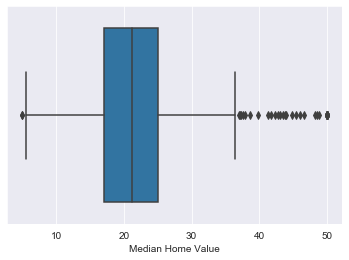

In [22]:
# generate boxplot of the target
sns.boxplot(y)
plt.show()

We will treat all median home values above $38,000 as outliers and drop the corresponding samples from the dataset. 

In [23]:
# drop samples deemed to be outliers
df2 = df[df['MEDV'] < 38]
# assign the features to X
X2 = df2.drop('MEDV', axis = 1)

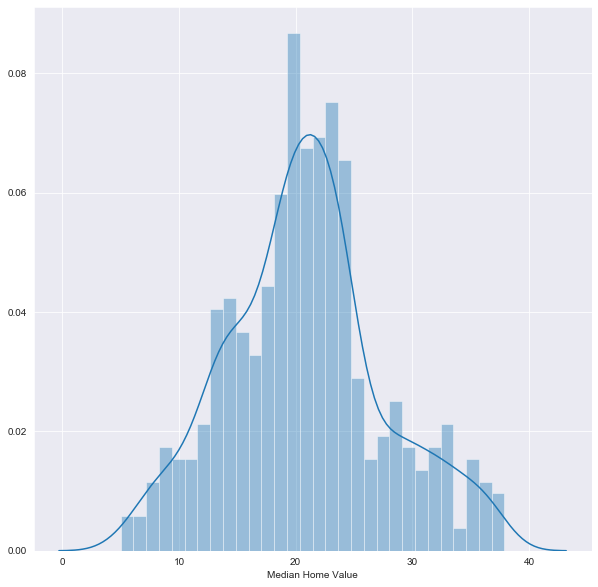

In [24]:
# plot the revised distribution of the target variable using seaborn
y2 = pd.Series(df2['MEDV'], name = 'Median Home Value')
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = sns.distplot(y2, bins = 30)
plt.show()

The target now displays a more acceptable distribution. We perform the cross-validated grid search again.

In [ ]:
# create the GridSearchCV object to find the optimum l1 ratio and alpha value
lin_reg_cv2 = GridSearchCV(pipeline, parameters, cv = 5)
# fit to the data
lin_reg_cv2.fit(X2, y2)
# compute the R^2 metric
r2_2 = lin_reg_cv2.best_score_
print("Tuned ElasticNet Alpha: {}".format(lin_reg_cv2.best_params_))
print("Tuned ElasticNet R squared: {:.2f}".format(r2_2))

Model performance has improved, but we will struggle to improve it further. Dropping some of the collinear features or using only the features most strongly correlated with the target offers no improvement in performance on this occasion.

For a multiple linear regression model we should use the adjusted coefficient of determination $\hat{R^2}$, which is defined as $$\hat{R^2} = 1 - (1-R^2)\frac{(n-1)}{(n-p-1)}$$
where $n$ is the number of samples, $R$ is the standard coefficient of determination and $p$ is the number of features.

In [ ]:
def adj_r2(r_squared, X):
    n, p = X.shape
    return 1 - (1 - r_squared)*((n - 1)/(n - p - 1))

print('Adjusted R^2 score for multiple linear regression: {:.2f}'.format(adj_r2(r2_2, X2)))